In [1]:
import numpy as np
import pandas as pd
import os
# from pyspark.ml.feature import Imputer
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pickle
import databricks.koalas as ks
from pyspark import SparkConf, SparkContext
# from pyspark import sql
# sql.setConf('spark.sql.shuffle.partitions', '10')
# spark = SparkSession.builder.getOrCreate()
# prev = spark.conf.get("spark.sql.execution.arrow.enabled")  # Keep its default value.
# ks.set_option("compute.default_index_type", "distributed")  # Use default index prevent overhead.
# import warnings
# warnings.filterwarnings("ignore")  # Ignore warnings coming from Arrow optimizations.

import databricks.koalas as ks

In [2]:
print(os.listdir('data/'))
# df_train = ks.read_csv('data/idc_train.csv')
# df_test = ks.read_csv('data/idc_test.csv')

df_train = pd.read_csv('data/idc_train.csv')
df_test = pd.read_csv('data/idc_test.csv')

['idc_test.csv', 'idc_train.csv']


In [10]:
df_train = df_train.sample(n=10000, replace=False) # 'working with a subest of train data'

In [11]:
def check_for_nulls(df):
    df.isnull().any()
    print("dropoff longitude nans: ", len(df['dropoff_longitude'][df['dropoff_longitude'].isnull() == True]))
    print("dropoff longitude nans: " , len(df['dropoff_latitude'][df['dropoff_latitude'].isnull() == True]))
check_for_nulls(df_train)

dropoff longitude nans:  0
dropoff longitude nans:  0


In [12]:
df_train.describe()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,high_fare
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0
mean,9.932145e+06,11.300627,-72.250082,40.261037,-72.286884,40.273836,1.674700,1.0
std,5.765999e+06,9.845221,28.213706,33.283966,28.167451,33.276742,1.298017,0.0
min,6.090000e+02,2.500000,-74.689830,-73.991960,-75.417710,-73.999756,0.000000,1.0
25%,4.913895e+06,6.000000,-73.991937,40.735075,-73.991490,40.733922,1.000000,1.0
50%,9.884914e+06,8.500000,-73.981514,40.752465,-73.980370,40.752829,1.000000,1.0
75%,1.497967e+07,12.500000,-73.966917,40.766524,-73.963438,40.768074,2.000000,1.0
max,1.998673e+07,221.660000,2551.566200,3315.078000,2551.566200,3315.078000,6.000000,1.0


In [25]:
def pre_process(df):
    df['high_fare'] = df['fare_amount'].mask(df['fare_amount'] <= 10, other=0)
    df['high_fare'] = df['high_fare'].mask(df['high_fare'] > 10, other=1)
    
    
        # Todo Spark imputer doesnt work (why?) , but it's only 137 rows, we can just remove them..
#     imputer = Imputer()
#     imputer.setInputCols(["dropoff_latitude", "dropoff_longitude"])
#     imputer.setOutputCols(["dropoff_latitude", "dropoff_longitude"])   
#     imputer.setStrategy("median").setMissingValue(1.0).fit(df).transform(df)
    df.dropna(inplace=True)
#     df = df.round({"pickup_longitude" : 4, 'pickup_latitude' : 4, "dropoff_longtiude" : 4, 'dropoff_latitude' : 4}) # TODO do we want to round it?

    return df
df_train_post = pre_process(df_train)   

<AxesSubplot:>

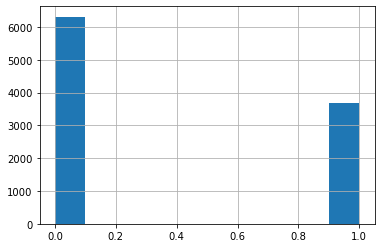

In [30]:
df_train_post['high_fare'].hist()

In [14]:
check_for_nulls(df_train_post)

dropoff longitude nans:  0
dropoff longitude nans:  0


In [15]:
len(df_train_post)

10000

## EDA

### Fare Amount , distributions and outliers removal

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'high_fare', 'distance', 'day_in_month',
       'day_in_week', 'month', 'year', 'is_weekend', 'Holiday'],
      dtype='object')


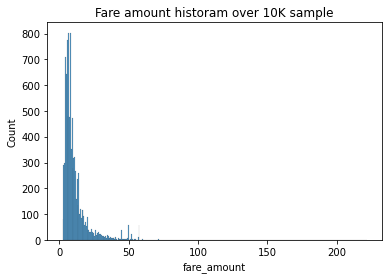

count    10000.000000
mean        11.300627
std          9.845221
min          2.500000
25%          6.000000
50%          8.500000
75%         12.500000
max        221.660000
Name: fare_amount, dtype: float64
10000


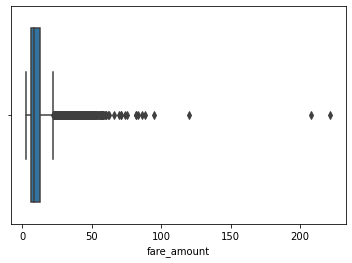

We can clearly see some outliers....


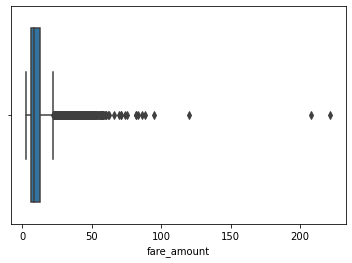

We removed 0 samples
Looking better... lets try to set the tresh at 500


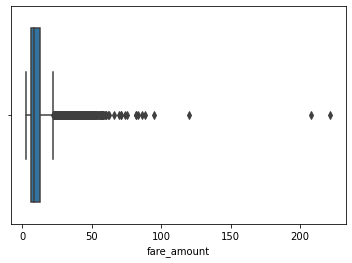

We removed 0 samples
Negitive fares? doesnt seem right.. lets remove them


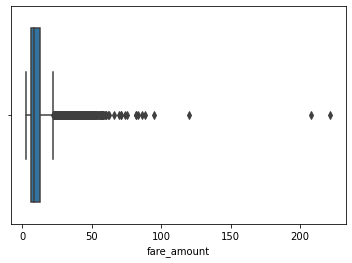

Looks good! now lets try to take a look at the dist of high fare


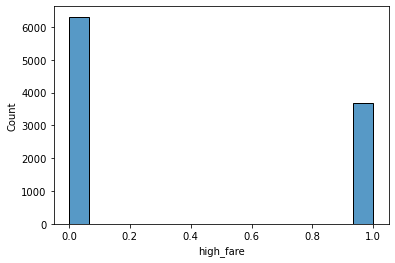

In [31]:
# sample_train = df_train_post.to_pandas().sample(frac=0.002, replace=False)

print(df_train_post.columns)
sns.histplot(data=df_train, x='fare_amount')
plt.title("Fare amount historam over 10K sample")
plt.show()

# pd_train_post = df_train.to_pandas()
print(df_train_post['fare_amount'].describe())
print(len(df_train_post['fare_amount']))
sns.boxplot(x=df_train_post['fare_amount'])
plt.show()
print("We can clearly see some outliers....")
below_10k = df_train_post[df_train_post['fare_amount'] < 10000].dropna()
sns.boxplot(x=below_10k['fare_amount'])
plt.show()
print("We removed {} samples".format(len(df_train_post) - len(below_10k)))
print("Looking better... lets try to set the tresh at 500")
below_05K = df_train_post[df_train_post['fare_amount'] < 500].dropna()
sns.boxplot(x=below_05K['fare_amount'])
plt.show()
print("We removed {} samples".format(len(df_train_post) - len(below_05K)))
print("Negitive fares? doesnt seem right.. lets remove them")
below_05K = below_05K[below_05K['fare_amount'] > 0].dropna()
sns.boxplot(x=below_05K['fare_amount'])
plt.show()
print("Looks good! now lets try to take a look at the dist of high fare")
below_05K = below_05K[below_05K['fare_amount'] > 0].dropna()
sns.histplot(data=below_05K, x='high_fare')
plt.show()

# sns.distplot(df_train[''], bins = 10 )

### Create haversine distance between pickup and dropoff

In [32]:
def haversine_distance(row):
    lat_p, lon_p = row['pickup_latitude'], row['pickup_longitude']
    lat_d, lon_d = row['dropoff_latitude'], row['dropoff_longitude']
    radius = 6371 # km

    dlat = np.radians(lat_d - lat_p)
    dlon = np.radians(lon_d - lon_p)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat_p)) * np.cos(np.radians(lat_d)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = radius * c

    return distance
# ks.set_option('compute.ops_on_diff_frames', True)
df_train_post['distance'] = df_train_post.apply(haversine_distance, axis = 1)

In [18]:
df_train_post['distance'].head()

14782088     2.967612
9941870     19.367878
17286922     5.075503
12112558     4.759351
17186024     0.000000
Name: distance, dtype: float64

In [19]:
with open('df_train_post.pkl', 'wb') as f:
    pickle.dump(df_train_post, f)

In [ ]:
with open('df_train_post.pkl', 'rb') as f:
    df_train_post = pickle.load(f)
    

### EDA distance 

In [ ]:
# pd_train_post = df_train.to_pandas()
distance_plot = df_train_post.where(df_train_post['distance'] < 50)
sns.histplot(data=df_train_post, x='distance', hue='high_fare', bins=100)
plt.show()

# sample_train = df_train_post.sample(n=10000, replace=False)

# sns.jointplot(data=sample_train, x='distance', y='fare_amount')
# plt.title("Jointplot of fare distance and amount")
# plt.show()

# sns.jointplot(data=sample_train, x='distance', y='high_fare')
# plt.title("Jointplot of fare distance and High fare")
# plt.show()


#### Reverse coords to geo features 

In [ ]:
from geopy.geocoders import Nominatim
# sqlContext.setConf('spark.sql.shuffle.partitions', '10')

columns = ['road', 'neighbourhood', 'suburb', 'county', 'city', 'postcode']
# def get_geo_features_pickup(row):
#     geolocator = Nominatim(user_agent="myGeocoder")
#     coors = str(row['pickup_latitude']) + ', ' + str(row['pickup_longitude'])
#     print(coors)
#     pick_up_location = geolocator.reverse(coors)
#     value = [0] * len(columns)
#     if pick_up_location:
#         value = [pick_up_location.raw.get('address').get(c) for c in columns]
#     return value


def get_geo_features_pickup(df):
    print("her")
    values = []
    geolocator = Nominatim(user_agent="myGeocoder")
    df['coors'] = df['pickup_latitude'].astype(str) + ', ' + df['pickup_longitude'].astype(str)
    vals = df['coors']
    batch_size = 1000
#     executor = ThreadPoolExecutor(max_workers=10)
#     for batch in range(0, len(df), batch_size):
#         pick_up_locations = [geolocator.reverse(c).raw.get('address') for c in df['coors'].values]
     
#         value = [0] * len(columns)
#         if pick_up_location:
#             value = [pick_up_location.raw.get('address').get(c) for c in columns]
#         values.append(value)
    return pick_up_locations
    

def get_geo_features_dropoff(row):
    geolocator = Nominatim(user_agent="myGeocoder")
    dropoff_location = geolocator.reverse(str(row['dropoff_latitude']) + ', ' +  str(row['dropoff_longitude']))
    value = [0] * len(columns)
    if dropoff_location:
        
        value = [dropoff_location.raw.get('address').get(c) for c in columns]
    value = [dropoff_location.raw.get('address').get(c) for c in columns]
    return value

In [ ]:
%%timeit
print(len(df_train_post))

# get_geo_features_pickup(df_train_post)

### Create Seasonal features

In [47]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'])
df_train['day_in_month'] = df_train['pickup_datetime'].dt.day
df_train['day_in_week'] = df_train['pickup_datetime'].dt.day_name()
df_train['month'] = df_train['pickup_datetime'].dt.month
df_train['year'] = df_train['pickup_datetime'].dt.year
df_train['hour'] = df_train['pickup_datetime'].dt.hour
df_train['is_weekend'] = df_train['day_in_week'].apply(lambda x: True if x in ['Friday', 'Saturday', 'Sunday'] else False)
holidays = calendar().holidays(start = df_train['pickup_datetime'].min(), end=df_train['pickup_datetime'].max())
df_train['holiday'] = df_train['pickup_datetime'].isin(holidays)


day_in_month


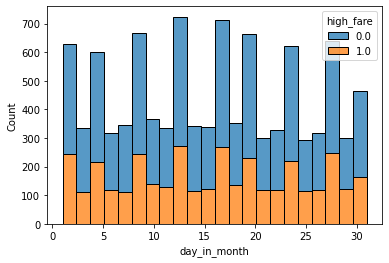

day_in_week


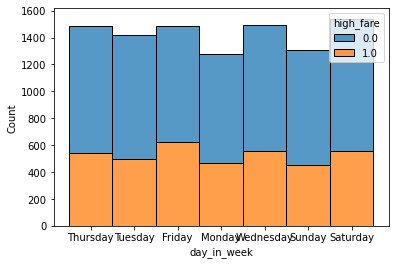

month


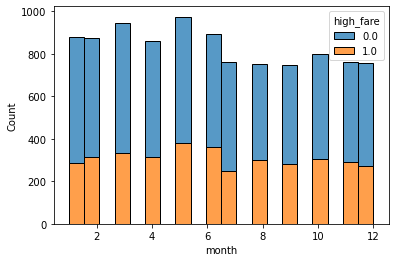

year


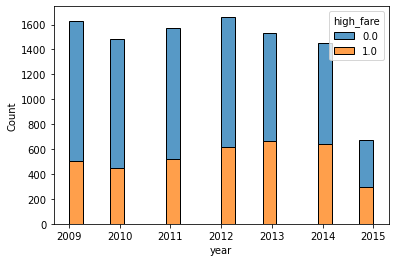

is_weekend


<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


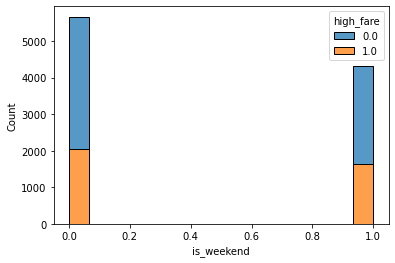

holiday


<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


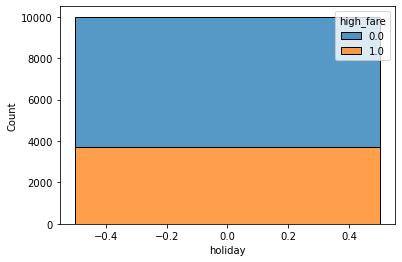

hour


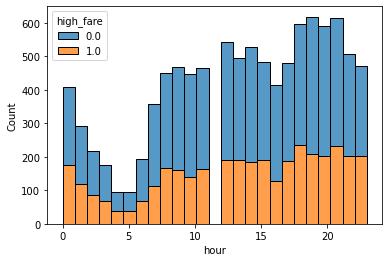

In [57]:
for c in ['day_in_month', 'day_in_week', 'month', 'year', 'is_weekend', 'holiday', 'hour']:
    print(c)
    sns.histplot(data =df_train , x=c , hue='high_fare', multiple="stack")
    plt.show()

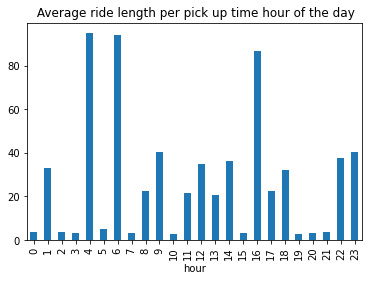

In [88]:
df_train.groupby('hour')['distance'].mean().plot(kind='bar', title=' Average ride length per pick up time hour of the day')
plt.show()

In [ ]:
df_train['Holiday'].describe()

In [ ]:
import folium

sample_train = df_train_post.sample(n=100, replace=False)
# create the map.
map_pickup = folium.Map( location=[sample_train['pickup_latitude'].mean(),sample_train['pickup_longitude'].mean()])

# adding the latitude and longitude points to the map.
sample_train.apply(lambda row:folium.CircleMarker(location=[row["pickup_latitude"], row["pickup_longitude"]] ).add_to(map_pickup), axis=1)
sample_train.apply(lambda row:folium.CircleMarker(location=[row["dropoff_latitude"], row["dropoff_longitude"]] , color='red').add_to(map_pickup), axis=1)

# display the map: just ask for the object representation in juypter notebook.
map_pickup 

# optional: save the map.
map_pickup.save('map_pickup.html')

In [ ]:
map_pickup